In [1]:
import numpy as np, scipy, skimage, time
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy import ndimage
import imageio
import matplotlib.pyplot as plt

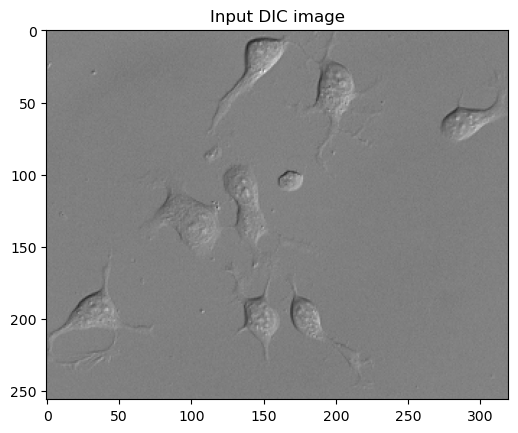

In [12]:
g = np.double(imageio.v2.imread("C:/Users/sam/Documents/Image Analysis/DICImage.tif"))
nrows, ncols = g.shape
N = nrows*ncols

xx, yy = np.meshgrid(np.arange(1, ncols+1), np.arange(1, nrows+1))
xx = xx.flatten(); yy = yy.flatten()
X = np.column_stack((np.ones(N), xx, yy, xx**2, xx*yy, yy**2))
p = np.linalg.lstsq(X, g.flatten(), rcond=None)[0]
g = np.reshape(g.flatten()-np.dot(X, p), (nrows,ncols))
g = g/np.max(np.abs(g)) #image value in [-1,1]
plt.imshow(g,cmap='gray', vmin=-1, vmax=1); plt.title('Input DIC image'); plt.show()

In [13]:
#compute the H (imaging model), L (smooth) matrices
tt = time.process_time() #use time instead of cputime
#get the differential kernel for H
sigma = 1 #sigma in the first-derivative-of-Gaussian kernel
theta = 225*np.pi/180+np.pi #this parameter is related to this given image's microscope parameter
radius = max(2*np.ceil(sigma),1).astype(int)
diameter = 2*radius + 1
xx,yy = np.meshgrid(np.arange(-radius,radius+1),np.arange(-radius,radius+1))
tmp = np.exp(-0.5*(xx**2 + yy**2)/sigma**2)
h_kernel = -(np.cos(theta)*xx+np.sin(theta)*yy)*tmp
h_kernel = h_kernel/np.sum(np.abs(h_kernel))

#build the sparse H matrix
nzidx = np.abs(h_kernel.flatten()) > 0.001 #save memory and speed up by ignoring small elements
inds = np.arange(1, N+1).reshape(nrows, ncols)
inds_pad = np.pad(inds, ((radius, radius), (radius, radius)), mode='symmetric') #deal with the boundary
row_inds = np.repeat(np.arange(1, N+1), np.sum(nzidx))
col_inds = np.ravel(np.array([inds_pad[i:i+diameter, j:j+diameter] for i in range(nrows) for j in range(ncols)])) #slide col and then row
col_inds = col_inds[np.tile(nzidx, N)]
vals = np.tile(h_kernel.flatten()[nzidx], N)
H = sp.csr_matrix((vals, (row_inds-1, col_inds-1)), shape=(N, N))


#get the smooth kernel for L
hwid = 1; wid = 2*hwid + 1; nsz = wid**2
D = -np.ones((wid,wid))/(nsz-1)
D[hwid,hwid] = 1


# build the sparse L matrix
inds = np.reshape(np.arange(1, N + 1), (nrows, ncols))
inds_pad = np.pad(inds, ((hwid, hwid), (hwid, hwid)), mode='symmetric')
row_inds = np.tile(np.arange(1, N + 1), (nsz, 1))
col_inds = skimage.util.view_as_windows(inds_pad, (wid, wid), step=1).reshape(-1, wid**2).T
vals = np.tile(D.ravel(), (N, 1)).T
L = scipy.sparse.coo_matrix((vals.ravel(), (row_inds.ravel() - 1, col_inds.ravel() - 1)), shape=(N, N)).tocsr()
print(f'get H and L: {time.process_time() - tt:.3f} seconds')

get H and L: 0.047 seconds


In [147]:
gamma = 1000
tol = .05
maxiter = 5000
w_sparsity = 1
w_smooth = .1

In [148]:
import time

Lambda_init = sp.diags(np.ones(N))
f_init = np.ones((N, 1))

g = g.flatten()
HT = H.T

f = f_init
Lambda =  Lambda_init

Q = HT@H + w_smooth * L
Q_p = sp.csr_matrix((Q > 0).multiply(Q))
Q_n = sp.csr_matrix((Q < 0).multiply(-Q))


for t in range(maxiter):
    f_c = np.copy(f)
    
    b = -HT@g + w_sparsity * Lambda.diagonal() / 2
    b = b.reshape((N, 1))
    
    Q_pf = Q_p@f
    Q_nf = Q_n@f
    
    r = 4 * Q_pf * Q_nf
    f = f * (-b + np.sqrt(b**2 + r)) / (2 * Q_pf)
  
    lid = Lambda_init.diagonal().copy()

    btm = f + gamma
    btm = btm.reshape((N, ))
    
    Lambda.setdiag( lid / btm)

    error = np.linalg.norm(f - f_c)
    
    if error < tol:
        break
   
    if t%100 == 0:
        print(f't={t}, error={error}')


t=0, error=119.8541768713796
t=100, error=0.18180912152952983
t=200, error=0.09975195304687318
t=300, error=0.0710525378664516
t=400, error=0.05569889524801267


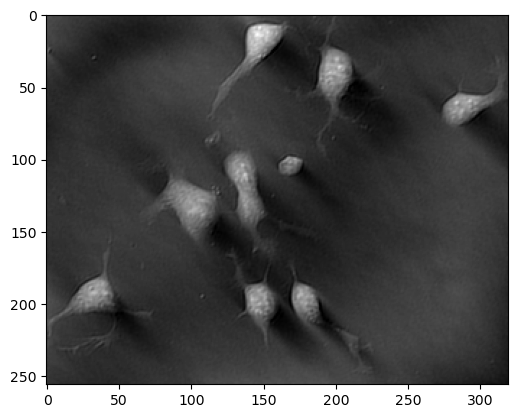

In [149]:
f = f.reshape(nrows, ncols)

plt.imshow(f, cmap='gray')